In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from matplotlib import rcParams
from datetime import datetime

df = pd.read_csv('international-airline-passengers.csv')
df.loc[:, 'Month']=pd.to_datetime(df.loc[:, 'Month'], format = '%Y-%m')
df = df.set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


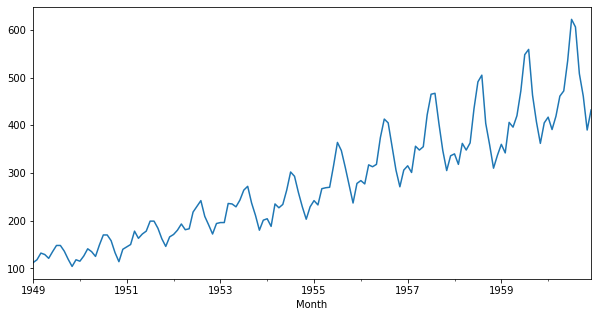

In [60]:
rcParams['figure.figsize'] = 10,5
df.Passengers.plot()
plt.show()
#震幅有隨時間越來越大的趨勢，令它為multiplicative

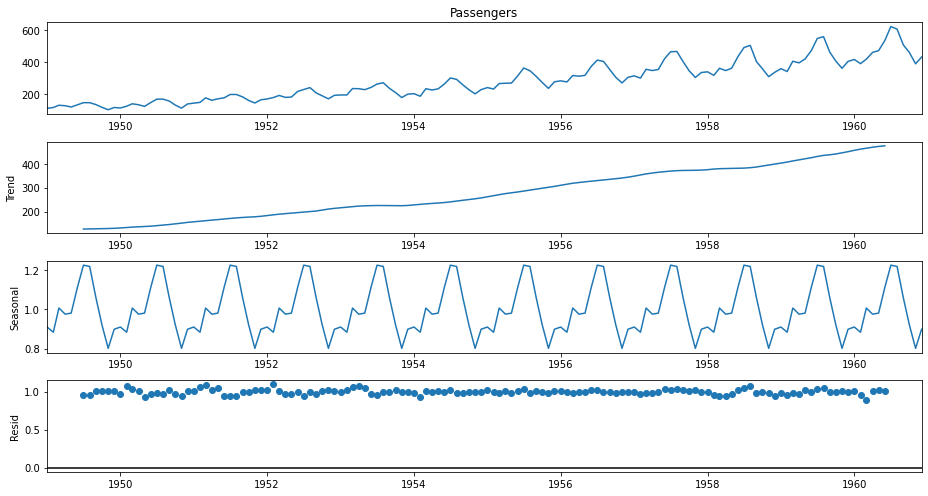

In [61]:
rcParams['figure.figsize'] = 13,7
# 載入時間序列資料
_ts = df.Passengers
# 時間序列分解
# 由Seasonal列可知此資料具有週期性
result_mul = seasonal_decompose(_ts, model='multiplicative')
result_mul.plot()
plt.show()

C:\Users\bp6c0\anaconda3\envs\ai3.7\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
C:\Users\bp6c0\anaconda3\envs\ai3.7\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


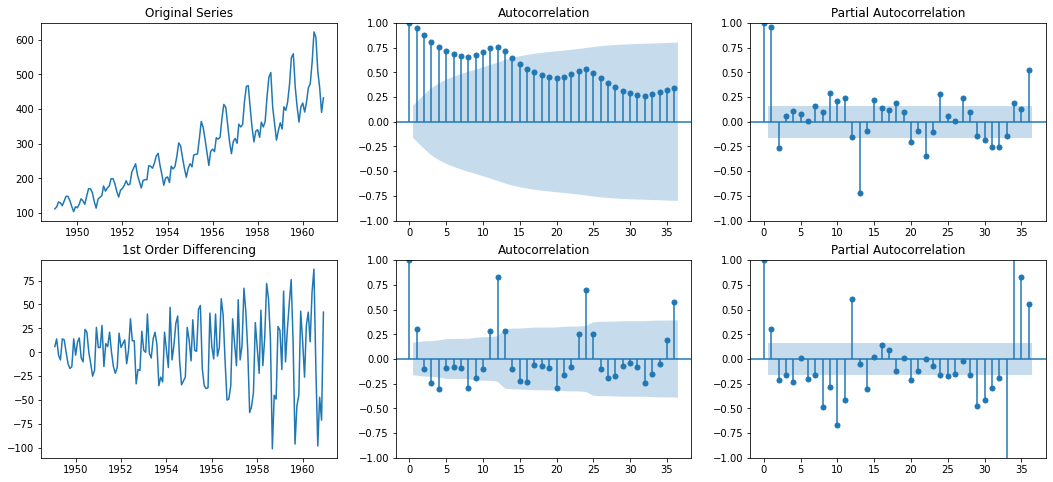

In [62]:
rcParams['figure.figsize'] = 18, 8

fig, axes = plt.subplots(2, 3, sharex=False)
axes[0, 0].plot(df.Passengers); axes[0, 0].set_title('Original Series')
plot_acf(df.Passengers, lags = 36, ax=axes[0, 1])
plot_pacf(df.Passengers, lags = 36, ax=axes[0, 2])
#拖尾超過10階以上，需進一步差分

# 一次差分(d=1)
axes[1, 0].plot(df.Passengers.diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Passengers.diff().dropna(), lags = 36, ax=axes[1, 1])
plot_pacf(df.Passengers.diff().dropna(), lags = 36, ax=axes[1, 2])
plt.show()
#經過一次差分後的ACF，每12階皆會出現一個極大值

In [4]:
#利用pmdarima找出最好的ARIMA參數進行預測
model = pm.auto_arima(df.Passengers, start_p=1, start_q=1,
                     information_criterion='aic',  #指定依AIC找出最好的參數
                     test='adf',                   #利用adf測試找出最佳d值
                     m=12,                         #約每12個月一次循環
                     max_p=3, max_q=3,
                     start_P=0,
                     seasonal=True,
                     d=None,
                     D=1, trace=True,
                     error_action='ignore',  
                     suppress_warnings=True, 
                     stepwise=False)

print(model.summary())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1030.752, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1032.276, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1030.408, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.18 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1034.096, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1020.639, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1019.494, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1020.327, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1012.991, Time=1.12 sec
 ARIM

In [ ]:
#coef顯示每個特徵的權重，而P>|z|是對每個特徵重要性的檢驗
#上表中每個權重的P-value皆小於0.05，因此保留所有權重是合理的

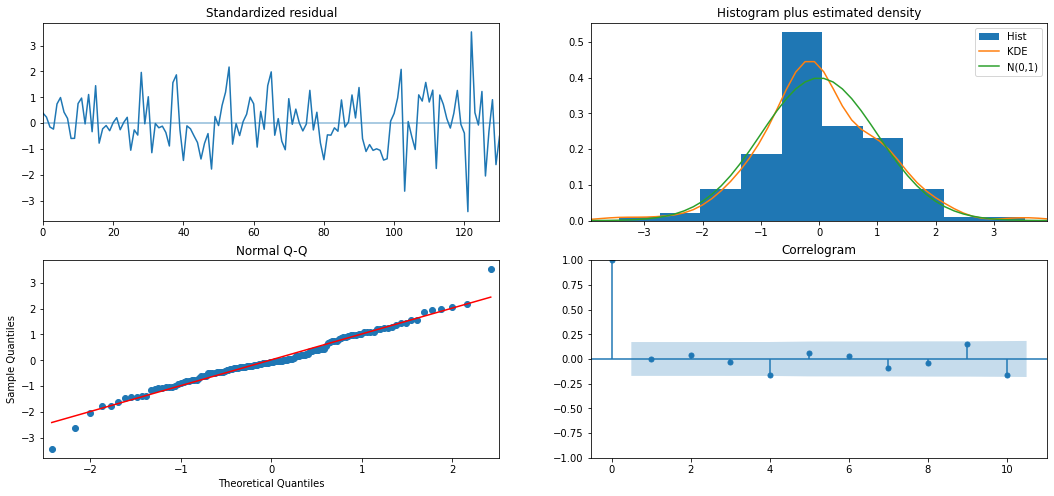

In [66]:
model.plot_diagnostics()
plt.show()
#左上:殘差沒有明顯的季節性變化，似乎是白噪聲
#右上:KDE線緊跟N(0, 1)(均值為0，標準差為1的正態分佈)，說明殘差是正態分佈的
#左下:殘差遵從具有N(0, 1)的正態分佈獲取的樣本線性趨勢，同樣說明殘差是正態分佈的
#右下:即ACF，表明殘差與自身的lag值具有較低的相關性

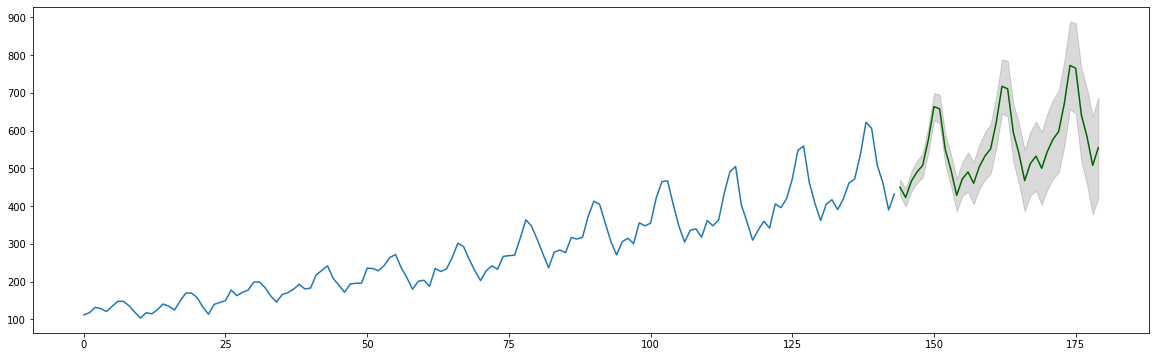

In [72]:
#模型參數皆合理，以下利用模型進行未來三年預測

rcParams['figure.figsize'] = 20,6
df.reset_index()

n_periods = 36
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df), len(df)+n_periods)

fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(df.Passengers.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()